# WB - Praca domowa nr 5

Jako model uzyty w pracy domowej wybrałem ResNet'a, a dokładniej model ResNet50. Wynika to z faktu, ze jest najlżejszym modelem spośród pozostałych "gotowców" kerasowych.

### Jak działa ResNet?
ResNet jest niczym innym jak pewną wariacją na temat sieci DNN. Inpiracją do jego stworzenia był fakt, że w wielu przypadkach przy dostatecznie dużej liczbie już użytych warstw dodawanie kolejnych wbrew oczekiwaniom zwiększało błąd zarówno na zbiorze treningowym, jak i testowym zamiast go zmnieijszać. Nie można tu było mówić o overfittingu, ponieważ takei zachowanie było dostrzegalne zarówno na zbiorze treningowym jak testowym. W celu uniknięcia takich anomalii w sieciach typu ResNet zostało umożliwione pomijanie pewnych warstw, tak jak na schemacie ponizej.


## 0. Importowanie odpowiednich bilbiotek

In [7]:
from PIL import Image
from keras.preprocessing.image import load_img
import numpy as np
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import tensorflow as tf
from keras.applications import mobilenet_v2
import matplotlib.pyplot as plt
from tensorflow import keras
import matplotlib.cm as cm

## 1. Klasyfikacja obrazów

In [8]:
res_model = tf.keras.applications.ResNet50(weights="imagenet")

In [9]:
def load_and_preprocess_image(path):
  image = img_to_array(load_img(path))
  return preprocess_input(image.reshape(1, image.shape[0], image.shape[1], image.shape[2]))

In [10]:
def classify_image_and_print_labels(model, image_path):
  plt.imshow(load_img(image_path))
  plt.show()
  labels = decode_predictions(model.predict(load_and_preprocess_image(image_path)))[0]
  for label in labels:
    print(f"Predicted label: {label[1]}, propability: {label[2]:.3f}")

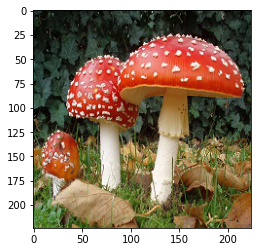

40960/35363 [==================================] - 0s 0us/step
Predicted label: agaric, propability: 0.840
Predicted label: mushroom, propability: 0.159
Predicted label: bolete, propability: 0.000
Predicted label: stinkhorn, propability: 0.000
Predicted label: hen-of-the-woods, propability: 0.000


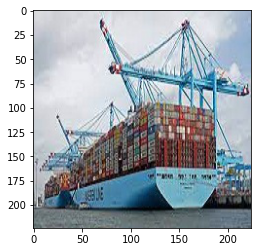

Predicted label: container_ship, propability: 0.999
Predicted label: liner, propability: 0.000
Predicted label: pirate, propability: 0.000
Predicted label: dock, propability: 0.000
Predicted label: wreck, propability: 0.000


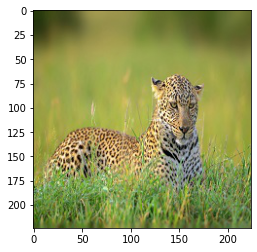

Predicted label: leopard, propability: 0.881
Predicted label: jaguar, propability: 0.100
Predicted label: cheetah, propability: 0.017
Predicted label: tiger_cat, propability: 0.001
Predicted label: tiger, propability: 0.000


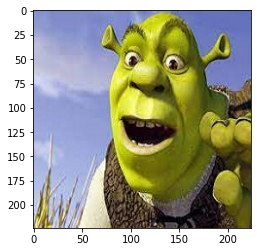

Predicted label: tennis_ball, propability: 0.266
Predicted label: mask, propability: 0.170
Predicted label: totem_pole, propability: 0.119
Predicted label: rapeseed, propability: 0.095
Predicted label: comic_book, propability: 0.079


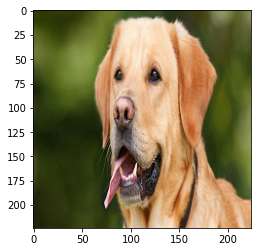

Predicted label: golden_retriever, propability: 0.743
Predicted label: Labrador_retriever, propability: 0.144
Predicted label: Tibetan_mastiff, propability: 0.022
Predicted label: bloodhound, propability: 0.014
Predicted label: kuvasz, propability: 0.009


In [11]:
classify_image_and_print_labels(res_model,"./images/grzyb.jpg")
classify_image_and_print_labels(res_model,"./images/ship.jpg")
classify_image_and_print_labels(res_model,"./images/leopard.jpg")
classify_image_and_print_labels(res_model,"./images/shrek.jpg")
classify_image_and_print_labels(res_model,"./images/labrador.jpg")

Widzimy, ze oprócz jedynego i niepowtarzalnego shreka oraz labradora, który został uznanego goldenem pozostałe 3 obrazki zostały prawidłowo zakwalifikowane. Zdjecie labradora nawet dla człowiek bezzłudnie przypomina goldena, tylko dla wprawionego oka widać te chrakterystyczne krótkie włosie i fałdki przy szyi :)  Teraz sprawdźmy za pomocą narzędzi XAI, co i w jakim stopniu odpowiadało za daną predykcję.

## 2. GRAD-CAM

Poniższy kod jest zaczerpniety z:
https://keras.io/examples/vision/grad_cam/

In [12]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [13]:
def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    plt.imshow(superimposed_img)
    plt.show()

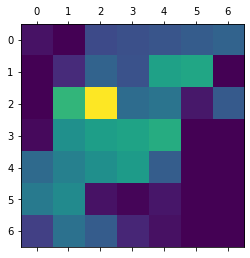

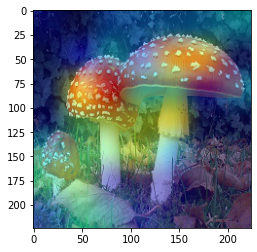

In [14]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(load_and_preprocess_image("./images/grzyb.jpg"), res_model, "conv5_block3_out")

# Display heatmap
plt.matshow(heatmap)
plt.show()

display_gradcam("./images/grzyb.jpg", heatmap, alpha = 0.8)

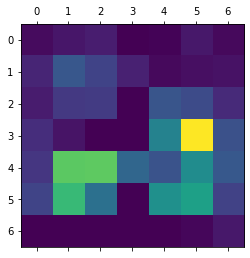

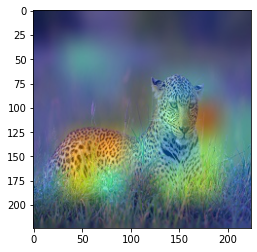

In [15]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(load_and_preprocess_image("./images/leopard.jpg"), res_model, "conv5_block3_out")

# Display heatmap
plt.matshow(heatmap)
plt.show()

display_gradcam("./images/leopard.jpg", heatmap, alpha = 0.8)

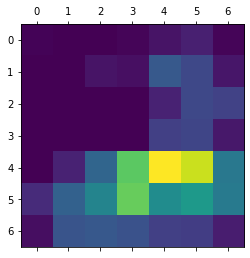

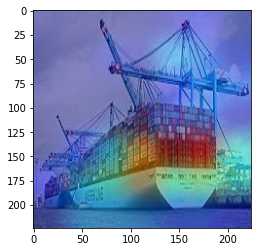

In [16]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(load_and_preprocess_image("./images/ship.jpg"), res_model, "conv5_block3_out")

# Display heatmap
plt.matshow(heatmap)
plt.show()

display_gradcam("./images/ship.jpg", heatmap, alpha = 0.8)

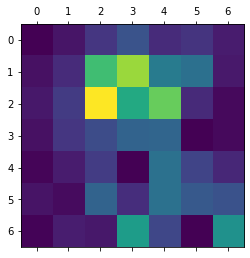

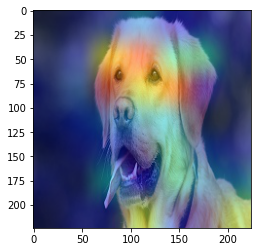

In [17]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(load_and_preprocess_image("./images/labrador.jpg"), res_model, "conv5_block3_out")

# Display heatmap
plt.matshow(heatmap)
plt.show()

display_gradcam("./images/labrador.jpg", heatmap, alpha = 0.8)

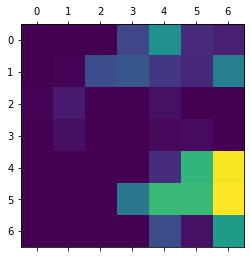

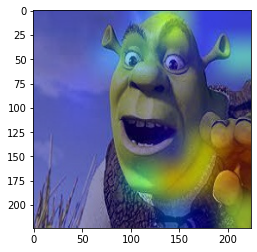

In [18]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(load_and_preprocess_image("./images/shrek.jpg"), res_model, "conv5_block3_out")

# Display heatmap
plt.matshow(heatmap)
plt.show()

display_gradcam("./images/shrek.jpg", heatmap, alpha = 0.8)

Używająć grad-cama możemy zauważyć, który fragment obrazu/zdjęcia był najbardziej kluczowy w określeniu **głównego** labela, czyli takiej klasy, dla której prawdopodobieństwo było największe. Ciekawym eksperymentem byłoby sprawdzenie jakby to wyglądało dla tych mniej prawdopodbnych klas - być moze wtedy inne fragmenty zdjecia byłby tymi, które wskazałyby na taką, a nie inną predykcję. Złą klasyfikację zdjećia z labradorem można uzasadnić trudnym zdjeciem, ponieważ nawet dla człowieka pies na zdjęciu bardziej przypomina goldena niz labradora. Niestety ciężko zuważyć na tym etapie co było tutaj głównym czynnikiem, moze LIME powie nam coś więcej. W powyższych przykładach oprócz labradora nie ma zdjęć, które byłyby dla modelu trudne do odgadnięcia. Shrek się nie liczy, ponieważ w klasach, które model przewiduje nie ma klasy dla naszego zieloengo ulubieńca. Natomiast dzięki uzyciu grad-cama jesteśmy w stanie zrozumieć, gdzie model "widział" na zdjęciu shreka piłeczkę tenisową - faktycznie zaznaczone miejsca są zielone i obłe, co jest cechą charakterystyczną każdej piłeczki tenisowej. To co jest ciekawe, to fakt jak niewielki fragment wystarczył do odgadniecia, że na zdjęciu znajduje się kontenerowiec.

## 3. LIME

In [21]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [33]:
def display_lim(image_path, model):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img_to_array(load_img(image_path, target_size=(224, 224))).astype('double'),model.predict, top_labels=3, hide_color=0, num_samples=500)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
    plt.imshow(np.clip(mark_boundaries(temp / 2 + 0.5, mask), 0, 1))


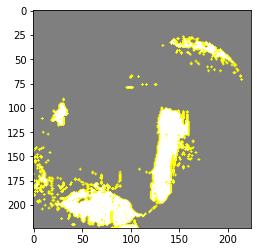

In [35]:
display_lim("./images/grzyb.jpg", res_model)

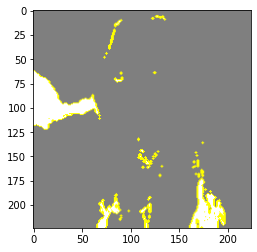

In [36]:
display_lim("./images/labrador.jpg", res_model)

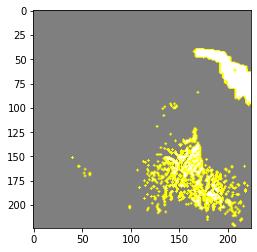

In [37]:
display_lim("./images/leopard.jpg", res_model)

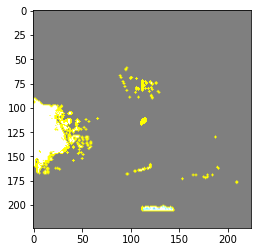

In [38]:
display_lim("./images/ship.jpg", res_model)

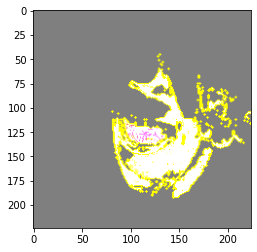

In [34]:
display_lim("./images/shrek.jpg", res_model)

Jeżeli chodzi o LIME to tutaj według mnie ciężej na oko dostrzec co odpowiadało za taką, a nie inną predykcję. W celu lepszego dostrzeżenia gfównych "featerów" zdjęcia można by nieco lepiej dobrać kontrast na poglądowych zdjęciach, natomiast nei udało mi sie tego osiągnąć. Natomiast tutaj widzimy nieco lepiej niż na grad-camie kontury i poszczególne elmenty zdjęcia, które przyczyniły się do predykcji. W ten sposób łatwiej "wyjąć" element z reszty zdjecia i zauważyć, które konkretnie piksele odpowiadały za taką, a nie inną decyzję. Natomiast bez wyplotowania zdjęcia obok ciężko dojść do wniosku, czym jest dany element.Myślę, że działanie LIME najlepiej widać na przykłądzie grzyba oraz wbrew pozorom Shreka. Tam faktycznie widać zarys tej piłęczki tenisowej, z którą został pomylony nasz przyjaciel o wielu warstwach.

## 4. Bilbiografia

https://www.mygreatlearning.com/blog/resnet/ 


https://keras.io/api/applications/

https://keras.io/examples/vision/grad_cam/
